## Experiment 2: Surrogate model

In this experiment we focus on how to use our method in the planning phase of a promotion. Let us illustrate the following situation. A retailer is interested in launching a promotion on a cold-start product. During the planning of the promotion the retailer chooses parameters such as the price of the product the type of display. In this experiment we explore five possible combinations of price and type of shelf and discuss how our method produces the forecast and selects the neighbours on a surrogate model.

This data model simulates the sales of 3 SKUs at a country level (constant number of stores) allowing to control the number of times that the product has been on promotion, the baseline sales, the price and discount range, and also the effects on the promotional sales of both the discount and the type of feature display.

We model the baseline sales of each product as a normal distribution $x_{b} \sim \mathcal{N}(\mu_b,\,\sigma^{2}_b)$. We simplify the type of promotions in our model to price cut deals, which allows us to model the discount as a half-normal distribution $x_{d} \sim \left| \mathcal{N}(0,\,\sigma^{2}_b) \right| \in [0, \infty)$. The deal effect curve~\cite{VanHeerde2001Semiparametric}, which connects discount and sales, is modelled as a shifted Gompertz distribution. In this setup, the sales increase with the discount reaching a point where they experience a decay. This saturation is typically observed in stock limited offers. The shifted Gompertz distribution at a time $t$, with scale parameter $b$ and shape parameter $\eta$ that is used in our examples is defined as:

\begin{equation}
f(t; b, \eta) = 1 + \left( 2.2 b e^{-bt} e^{-\eta e^{-bt}} [1 + \eta (1 -e^{-bt})] \right)
\end{equation}

The deal effect curves are can be produced with ADD_NAME, where the blue line represents product P1, a product where discounts do not make a large difference as the product is normally included in the regular basket, for example, produce products.
Product P2 is represented by the orange line, and in this case, the discount rapidly increases the sales up to the point of running out of stock, affecting sales negatively. Finally, in green colour line there is product P3, which represents a real case scenario that we have particularly observed in Asian markets, where there are certain products for which a small price cut can rapidly increase sales. As a byproduct the shelves are empty very quickly resulting in a negative customer experience.

In [1]:
import matplotlib
from mpl_toolkits import mplot3d
import category_encoders as ce
import pandas as pd
import numpy as np
from os import path as _p
from contrastiveRegressor import contrastiveRegressor
from common_metrics import get_frc_errors

from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool

import seaborn as sns
import matplotlib.pyplot as plt
import preprocessing_utils as pt
from generate_Gompertz_sales import generate_Gompertz_sales
import fcn_helpers as fhelp


In /usr/local/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /usr/local/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /usr/local/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:

# PRODUCT 1 >> Milk
num_samples = 100
# Baseline sales
mu_sales = 80
sigma_sales = 6
# Price
price_mu = 80
# Discount
discount_sigma = 8.2
# Shelves
shelf_capacity = [12, 10, 8, 6]
shelf_impact = 2.5
# Gompertz
b_scale   = 0.3
eta_shape = 8.0
# Generate sales
df_A = generate_Gompertz_sales(num_samples, mu_sales, sigma_sales,
  price_mu, discount_sigma, shelf_capacity, shelf_impact,
  b_scale, eta_shape)
df_A['product'] = 'P1'
df_A.head()



# PRODUCT 2 >> Chocolates
num_samples = 80
# Baseline sales
mu_sales = 40
sigma_sales = 4.5
# Price
price_mu = 100
# Discount
discount_sigma = 6.0
# Shelves
shelf_capacity = [5, 4, 3, 6]
shelf_impact = 1.5
# Gompertz
b_scale   = 0.3
eta_shape = 8.0
# Generate sales
df_B = generate_Gompertz_sales(num_samples, mu_sales, sigma_sales,
  price_mu, discount_sigma, shelf_capacity, shelf_impact,
  b_scale, eta_shape)
df_B['product'] = 'P2'



# PRODUCT 3 >> Rice in Thailand
num_samples = 95
# Baseline sales
mu_sales = 140
sigma_sales = 8
# Price
price_mu = 62
# Discount
discount_sigma = 1.75
# Shelves
shelf_capacity = [8, 4, 14, 6]
shelf_impact = 1.85
# Gompertz
b_scale   = 0.8
eta_shape = 4.0
# Generate sales
df_C = generate_Gompertz_sales(num_samples, mu_sales, sigma_sales,
  price_mu, discount_sigma, shelf_capacity, shelf_impact,
  b_scale, eta_shape)
df_C['product'] = 'P3'

df = pd.concat([df_A.iloc[:-2, :], df_B.iloc[:-2, :], df_C.iloc[:-2, :]], ignore_index=True)
                
# To evaluate the sugggestion of reviewer #2
df_test_products = pd.concat([df_A.iloc[-2::,:], df_B.iloc[-2::,:], df_C.iloc[-2::,:]], ignore_index=True)

# Save the example so it's reproducible
filePath = _p.join('data', 'toy_example.pickle')
fhelp.toPickleFile(df, filePath)

df

,price,discount,baseline_sales,shelves,shelf_sales,product_sales,product
0,76.179534,3.820466,78.551617,8,8.344264,95.263680,P1
1,70.478704,9.521296,81.847429,8,9.464598,108.054162,P1
2,78.253742,1.746258,78.132465,8,7.610159,86.882647,P1
3,70.441487,9.558513,70.250618,12,12.174093,96.716405,P1
4,62.102769,17.897231,85.098619,10,10.482918,97.840572,P1
...,...,...,...,...,...,...,...
264,59.436306,2.563694,143.240129,14,28.616821,258.803601,P3
265,59.646177,2.353823,141.353451,6,12.349990,244.144097,P3
266,60.722287,1.277713,127.072556,8,13.853667,208.865868,P3
267,60.598088,1.401912,133.588289,4,7.477650,217.997071,P3


In [3]:
df_test_products

,price,discount,baseline_sales,shelves,shelf_sales,product_sales,product
0,79.428253,0.571747,70.295872,8,6.758446,77.158922,P1
1,75.157453,4.842547,78.121758,6,6.577552,97.932444,P1
2,92.189988,7.810012,38.763488,4,1.386549,49.530613,P2
3,76.697028,23.302972,35.874571,3,0.779092,36.848161,P2
4,61.040067,0.959933,132.281081,4,6.584360,191.954857,P3
5,61.304641,0.695359,150.615526,8,13.649203,205.783249,P3


In [4]:
# Test set: aim for regions where the data is pretty scarce 
df_test = pd.DataFrame({'price': [63,65,70,85,95],
  'shelves': [6,13,11,6,10]})

In [5]:
# Variables for the model
responseVar   = 'product_sales'
identifierVar = 'product'

## Model
numerical_vars = ['price']
categoricalVars = ['shelves']
input_vars = numerical_vars + categoricalVars

X_train = df[input_vars].values
y_train = df[responseVar].values

In [6]:
numericalVars = input_vars
categoricalVars = []

num_inputVars = len(input_vars)

# Hyper-parameters
num_neighbours = 5
validation_test_size = 0.20
feat_importance_keyword = 'feature_importances_'
# Regressor
num_iterations = 800
learning_rate  = 0.08 
depth = 12
# CatBoost
cb_model = CatBoostRegressor(iterations=num_iterations, learning_rate=learning_rate,
depth=depth, loss_function='RMSE', cat_features=categoricalVars, silent=True)
# Create the forecaster
contrastiveReg = contrastiveRegressor(num_neighbours = num_neighbours, 
  validation_test_size = validation_test_size)

# Set the regressor
contrastiveReg.set_regressor(cb_model, feat_importance_keyword, input_vars)
# fit the regressor
contrastiveReg.fit(X_train, y_train)
# eval results
contrastiveReg.predict_eval_test()
eval_results = contrastiveReg.get_results()

Preparing Training set...
Training set (1075, 4). Evaluation (270, 4)...done.
...Symmetrical Weights
MAE: 6.16
MSE: 100.28
RMSE: 10.01
meanError: -1.69
MAPE: 5.28
R2: 0.98
frc_error: 0.05
frc_bias: -0.01
frc_acc: 1.01
Var explained: 0.98


In [7]:
# Predict
contrastiveReg.predict(df_test.values)
cold_start_results = contrastiveReg.get_results()

...Symmetrical Weights


In [8]:
# Sort by importance
df_feature_importances = cold_start_results.get('df_feat_importances', None)
df_feature_importances.columns = ['variable_importance']
df_feature_importances

,variable_importance
price,88.484018
shelves,11.515982


In [9]:
# Arrange the results in a DF so we can easily plot them
df_frc = df_test.copy()
df_frc['y_hat'] = cold_start_results['y_hat_weighted']


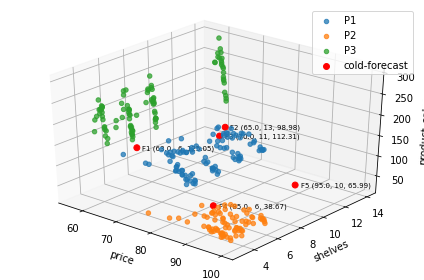

In [10]:
'''
  Checkpoint to see what the sales look like
'''
varX = 'price'
varY = 'shelves'
varZ = 'product_sales'

_alpha = 0.75
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter(df_A[varX], df_A[varY], df_A[varZ], alpha=_alpha, label=df_A.loc[0, 'product'])
ax.scatter(df_B[varX], df_B[varY], df_B[varZ], alpha=_alpha, label=df_B.loc[0, 'product'])
ax.scatter(df_C[varX], df_C[varY], df_C[varZ], alpha=_alpha, label=df_C.loc[0, 'product'])
# Also plot the test points
ax.scatter(df_frc[varX], df_frc[varY], df_frc['y_hat'], alpha=1.0, label='cold-forecast', color='red', s=35)

for idx, row in df_frc.iterrows():
    point_name = f'F{(1+idx)} ({row[varX]}, {row[varY]:2.0f}, {row.y_hat:3.2f})'
    ax.text(row[varX]+1.5,row[varY],row['y_hat'], point_name, color='black', fontsize=7)

ax.set_xlabel(varX)
ax.set_ylabel(varY)
ax.set_zlabel(varZ)

ax.view_init(elev=32, azim=-50)
ax.legend()
ax.grid(True)

plt.tight_layout()
#plt.show(block = True)


### Is our method good with products that are regular sellers?

In [11]:
# Predict
contrastiveReg.predict(df_test_products[input_vars].values)
cold_start_results = contrastiveReg.get_results()

...Symmetrical Weights


In [12]:
df_test_products

,price,discount,baseline_sales,shelves,shelf_sales,product_sales,product
0,79.428253,0.571747,70.295872,8,6.758446,77.158922,P1
1,75.157453,4.842547,78.121758,6,6.577552,97.932444,P1
2,92.189988,7.810012,38.763488,4,1.386549,49.530613,P2
3,76.697028,23.302972,35.874571,3,0.779092,36.848161,P2
4,61.040067,0.959933,132.281081,4,6.584360,191.954857,P3
5,61.304641,0.695359,150.615526,8,13.649203,205.783249,P3


In [13]:
# Predict with CatBoost (original)
y_hat_catboost = fhelp.frc_plain_CatBoost(num_neighbours, validation_test_size,
    num_iterations, learning_rate, depth, \
    contrastiveReg.X_train, contrastiveReg.y_train, df_test_products[input_vars].values)


0:	learn: 64.9907722	test: 66.5029480	best: 66.5029480 (0)	total: 2.42ms	remaining: 1.94s
50:	learn: 12.3123178	test: 11.0919223	best: 11.0919223 (50)	total: 256ms	remaining: 3.76s
100:	learn: 8.4786849	test: 10.7478802	best: 10.5948090 (68)	total: 668ms	remaining: 4.62s
150:	learn: 6.5628064	test: 10.9180820	best: 10.5948090 (68)	total: 1.34s	remaining: 5.76s
200:	learn: 5.3239197	test: 11.0181266	best: 10.5948090 (68)	total: 2.16s	remaining: 6.45s
250:	learn: 4.5744610	test: 11.1700740	best: 10.5948090 (68)	total: 3.02s	remaining: 6.6s
300:	learn: 3.9719261	test: 11.2294620	best: 10.5948090 (68)	total: 3.68s	remaining: 6.1s
350:	learn: 3.5009742	test: 11.3355966	best: 10.5948090 (68)	total: 4.32s	remaining: 5.53s
400:	learn: 3.1088893	test: 11.4442277	best: 10.5948090 (68)	total: 5.05s	remaining: 5.02s
450:	learn: 2.7864560	test: 11.4994070	best: 10.5948090 (68)	total: 5.79s	remaining: 4.49s
500:	learn: 2.5061272	test: 11.5803307	best: 10.5948090 (68)	total: 6.51s	remaining: 3.89s
5

In [14]:
# Predict with Extra Random Trees (sklearn)
y_hat_ERT = fhelp.frc_plain_extratrees(num_neighbours, depth, validation_test_size, 
                                            contrastiveReg.X_train, contrastiveReg.y_train, df_test_products[input_vars].values)

In [15]:
# Predict with NGBoost
y_hat_NGBoost = fhelp.frc_plain_ngboost(num_iterations, learning_rate, validation_test_size, 
                                        contrastiveReg.X_train, contrastiveReg.y_train, 
                                        df_test_products[input_vars].values)

[iter 0] loss=5.6612 val_loss=5.6579 scale=0.0625 norm=3.5763
[iter 100] loss=5.1920 val_loss=5.2053 scale=0.1250 norm=4.0057
[iter 200] loss=4.3277 val_loss=4.3794 scale=0.5000 norm=4.3816
[iter 300] loss=2.7319 val_loss=28.0306 scale=1.0000 norm=3.7073
[iter 400] loss=2.2903 val_loss=109.7415 scale=1.0000 norm=2.6775
[iter 500] loss=2.1418 val_loss=150.5475 scale=0.0010 norm=0.0023
[iter 600] loss=2.1269 val_loss=154.8489 scale=0.0010 norm=0.0023
[iter 700] loss=2.1270 val_loss=154.9631 scale=0.0010 norm=0.0023


In [16]:
df_test_products['y_hat_catboost'] = y_hat_catboost
df_test_products['y_hat_extratrees'] = y_hat_ERT
df_test_products['y_hat_ngboost'] = y_hat_NGBoost
df_test_products['y_hat_contrastive'] = cold_start_results['y_hat_weighted']
df_test_products

,price,discount,baseline_sales,shelves,shelf_sales,product_sales,product,y_hat_catboost,y_hat_extratrees,y_hat_ngboost,y_hat_contrastive
0,79.428253,0.571747,70.295872,8,6.758446,77.158922,P1,82.768575,88.109100,87.775767,84.112137
1,75.157453,4.842547,78.121758,6,6.577552,97.932444,P1,105.044956,114.513707,106.898397,99.536511
2,92.189988,7.810012,38.763488,4,1.386549,49.530613,P2,47.735824,61.295704,50.149122,58.335947
3,76.697028,23.302972,35.874571,3,0.779092,36.848161,P2,97.401123,75.163398,96.403841,65.694634
4,61.040067,0.959933,132.281081,4,6.584360,191.954857,P3,209.281214,199.891169,210.644324,206.276236
5,61.304641,0.695359,150.615526,8,13.649203,205.783249,P3,194.370169,194.414357,182.507517,204.606867


#### Compare the 3 regressors

In [17]:
y_test = df_test_products['product_sales']
contrastive_frc_metrics = contrastiveReg.get_frc_errors(y_test, df_test_products['y_hat_contrastive'], False)
catboost_frc_metrics = contrastiveReg.get_frc_errors(y_test, df_test_products['y_hat_catboost'], False)
xrt_frc_metrics = contrastiveReg.get_frc_errors(y_test, df_test_products['y_hat_extratrees'], False)
ngboost_frc_metrics = contrastiveReg.get_frc_errors(y_test, df_test_products['y_hat_ngboost'], False)

for k in contrastive_frc_metrics.keys():
    a = contrastive_frc_metrics[k]
    b = catboost_frc_metrics[k]
    c = xrt_frc_metrics[k]
    d = ngboost_frc_metrics[k]
    print(f'\n{k} >>\n\tcontrastive: {a:3.2f}\n\tCatBoost: {b:3.2f}\n\tNGBoost:{d:3.2f}\n\tERT: {c:3.2f}')


MAE >>
	contrastive: 10.28
	CatBoost: 17.30
	NGBoost:20.29
	ERT: 16.15

MSE >>
	contrastive: 194.51
	CatBoost: 697.07
	NGBoost:771.90
	ERT: 365.59

RMSE >>
	contrastive: 13.95
	CatBoost: 26.40
	NGBoost:27.78
	ERT: 19.12

meanError >>
	contrastive: -9.89
	CatBoost: -12.90
	NGBoost:-12.53
	ERT: -12.36

MAPE >>
	contrastive: 19.12
	CatBoost: 32.84
	NGBoost:34.47
	ERT: 28.09

R2 >>
	contrastive: 0.96
	CatBoost: 0.84
	NGBoost:0.82
	ERT: 0.92

frc_error >>
	contrastive: 0.09
	CatBoost: 0.16
	NGBoost:0.18
	ERT: 0.15

frc_bias >>
	contrastive: -0.08
	CatBoost: -0.11
	NGBoost:-0.10
	ERT: -0.10

frc_acc >>
	contrastive: 1.08
	CatBoost: 1.11
	NGBoost:1.10
	ERT: 1.10

Var explained >>
	contrastive: 0.98
	CatBoost: 0.88
	NGBoost:0.86
	ERT: 0.95
